# 1. Fitter
### Находит параметры и решение, наиболее подогнанное к данным по метрике MSE

In [1]:
import math
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint
import sys

try:
    from tqdm.notebook import tqdm
except Exception:
    print('For a nice progress bar install tqdm (pip3 install tqdm)', file=sys.stderr)
    def tqdm(iterable, *args, **kwargs):
        return iterable

    
def progress_wrapper(iterable, level, max_progress_level):
    if level == 0:
        return tqdm(iterable)
    elif level <= max_progress_level:  # configurable
        return tqdm(iterable, leave=False)
    else:
        return iterable
    

def compute_loss(time_points, predicted_metrics, true_metrics):
    loss_sum = 0.0
    # Iterace through infected, recovered and dead
    for predicted, true in zip(predicted_metrics, true_metrics):
        assert predicted.shape[0] == true.shape[0], "expected solution's size to be {}, but got {}".format(true.shape[0], predicted.shape[0])
        loss_sum += np.mean((true - predicted) ** 2)
    return loss_sum


def cut_metrics(metrics, from_idx, to_idx):
    if to_idx is None:
        return [x[from_idx:] for x in metrics]
    else:
        return [x[from_idx:to_idx] for x in metrics]


def fit(ode_system_getter, time_points, params, to_metrics, true_metrics, max_progress_level=1, val_samples=0):
    """
    ode_system_getter: функция, которая получает набор параметров из params и возвращает tuple,
                       в котором первый элемент – функция, задающая систему уравнений
                       (и принимающая только параметры y и t)
                       и соответствующая аргументу func функции scipy.integrate.odeint,
                       а второй элемент – вектор начальных условий y0 функции scipy.integrate.odeint
    time_points: точки, для которых нужно решить систему уранений. Аналогично параметру t в scipy.integrate.odeint
    params: список, в котором каждый i-тый элемент –
            список возможных значений i-того параметра, передаваемого в ode_system_getter
    to_metrics: функция, принимающая solution (результат функции scipy.integrate.odeint)
                и отдающая список метрик, по которым будет производиться оценка параметров.
                каждая метрика – одномерный numpy-массив значений
    true_metrics: список метрик для данных, под которые мы подстраиваемся
                  каждая метрика – одномерный numpy-массив значений
    max_progress_level: глубина вложенных циклов, для которых будет отображаться progress-bar. Считается от 0.
    val_samples: количество элементов, отсекаемых на валидацию.
                 целое число означает количество элементов,
                 дробное в интервале (0;1) – долю от общего числа элементов
                  
    
    """
    
    val_len = math.ceil(len(time_points)*val_samples) if val_samples < 1 else val_samples
    train_len = len(time_points) - val_len
    assert train_len > 0, 'Too big value for val_samples, no train samples left'
    if val_len <= 0:
        print('Too small value for val_samples, no validation loss will be computed', file=sys.stderr)
    train_points = time_points[:train_len]
    val_points = time_points[train_len:]
    true_train = cut_metrics(true_metrics, 0, train_len)
    true_val = cut_metrics(true_metrics, train_len, None)
    
    def fit_stage(left_params, current_values, level):
        if left_params:
            best_train_loss = None
            best_val_loss = None
            best_solution = None
            best_params = None
            for param_value in progress_wrapper(left_params[-1], level, max_progress_level):
                new_values = current_values + (param_value,)
                return_value = fit_stage(left_params[:-1], new_values, level+1)
                if return_value is None:
                    continue
                train_loss, val_loss, solution, params_for_loss = return_value
                if best_train_loss is None or best_train_loss > train_loss:
                    best_train_loss = train_loss
                    best_val_loss = val_loss
                    best_solution = solution
                    best_params = params_for_loss
            return best_train_loss, best_val_loss, best_solution, best_params
        else:
            return_value = ode_system_getter(*current_values)
            if return_value is None:  # e.g. invalid parameters
                return None
            ode_system, initial_conditions = return_value
            solution = odeint(ode_system, initial_conditions, time_points)
            train_loss = compute_loss(train_points, cut_metrics(to_metrics(solution), 0, train_len), true_train)
            if val_len > 0:
                val_loss = compute_loss(val_points, cut_metrics(to_metrics(solution), train_len, None), true_val)
            else:
                val_loss = 0.0
            return train_loss, val_loss, solution, current_values
    
    best_train_loss, val_loss, best_solution, best_params = fit_stage(params, tuple(), 0)
    return best_train_loss, val_loss, best_solution, tuple(reversed(best_params))

# 2. Пример использования для простой SIR-модели

### Так задаются все входные данные

In [2]:
# Список возможных значений параметров SIR-модели
params = [  
    np.linspace(0.1, 1, 100),  # beta:  0.1...1
    np.linspace(0.1, 1, 100),  # gamma: 0.1...1
]

# Функция, которая принимает параметры beta и gamma и отдаёт систему уравнений и начальные условия
def func_getter(beta, gamma):
    initial_conditions =np.zeros(3)
    initial_conditions[0] = 99
    initial_conditions[1] = 1
    
    def ode_system(y,t): 
        dy=[0,0,0]
        dy[0] = -beta*y[1]*y[0]/99  # S
        dy[1] = beta*y[1]*y[0]/99 - gamma*y[1]  # I
        dy[2] = gamma*y[1]

        return dy
    
    return ode_system, initial_conditions

# Функция, по решению отдающая метрики
def solution_to_metrics(solution):
    return solution[:, 0], solution[:, 1], solution[:, 2]

# "Реальные" данные, под которые мы будем подстраиваться
time_points = [0, 10, 20]
true_data = [
    np.array([99, 50, 0]),
    np.array([1,   40, 1]),
    np.array([0, 10, 99]),
]

### Поиск наилучшего решения

In [3]:
train_loss, val_loss, best_solution, best_params = fit(
    func_getter,
    time_points,  # [0, 10, 20]
    params,
    solution_to_metrics,
    true_data,
    max_progress_level=0,  # вложенный прогресс-бар тут только мельтешит
    val_samples=1
)
print(train_loss, val_loss, best_params)


5.625071278837448 2971.9454261976366 (0.1, 0.5454545454545454)


In [4]:
# Небольшая функция для быстрой отрисовки графичков. Можно переиспользовать
def plot_data(time_points, data, upper_limit, labels=None):
    susceptible, infected, recovered = true_data
    
    plt.figure(figsize=(13,5))
    plt.subplot(1,2,1)
    for y in data:
        plt.plot(time_points, y)
        
    plt.xlabel("Time (days)")
    plt.ylabel("Number of people")
    if labels:
        plt.legend(labels)
    plt.ylim([0, upper_limit])

    #Same plot but on log scale
    plt.subplot(1,2,2)
    for y in data:
        plt.plot(time_points, y)
    plt.semilogy()
    plt.xlabel("Time (days)")
    plt.ylabel("Number of people")
    if labels:
        plt.legend(labels)
    plt.ylim([0.001, upper_limit])

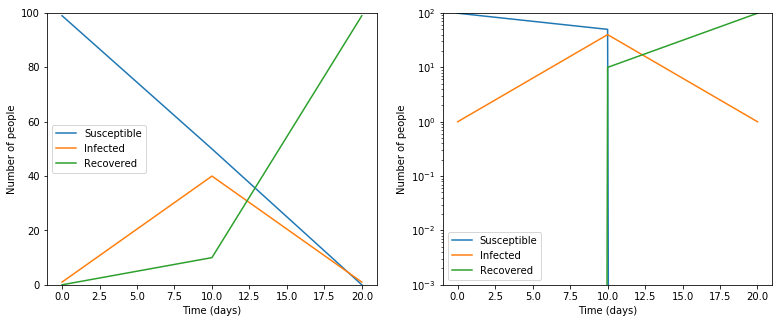

In [5]:
# "Реальные" данные
plot_data(time_points, true_data, 100, labels=["Susceptible", "Infected", "Recovered"])

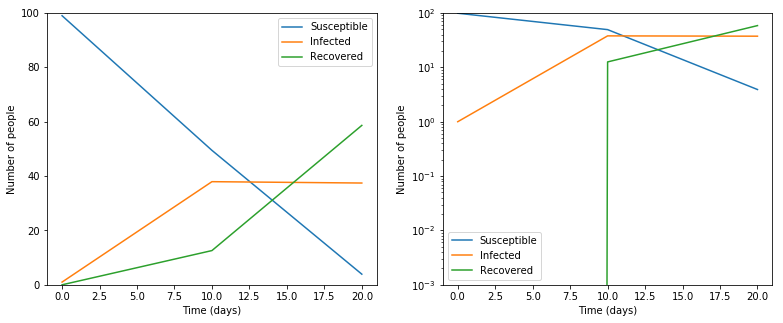

In [6]:
# Модель с наилучшими параметрами
plot_data(time_points, solution_to_metrics(best_solution), 100, labels=["Susceptible", "Infected", "Recovered"])

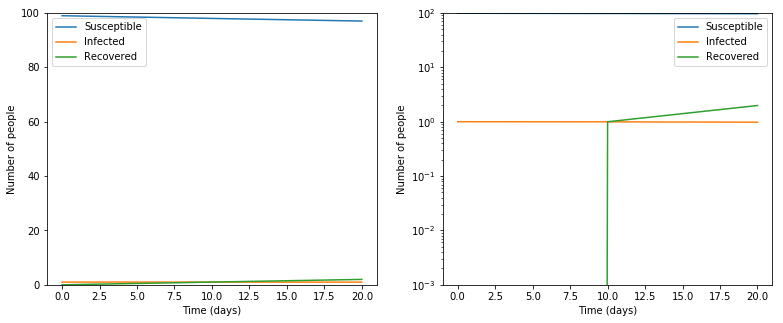

In [7]:
# Рандомно выбранные параметры (плохие)
func, ic = func_getter(0.1, 0.1)
solution = odeint(func, ic, time_points)
plot_data(time_points, solution_to_metrics(solution), 100, labels=["Susceptible", "Infected", "Recovered"])

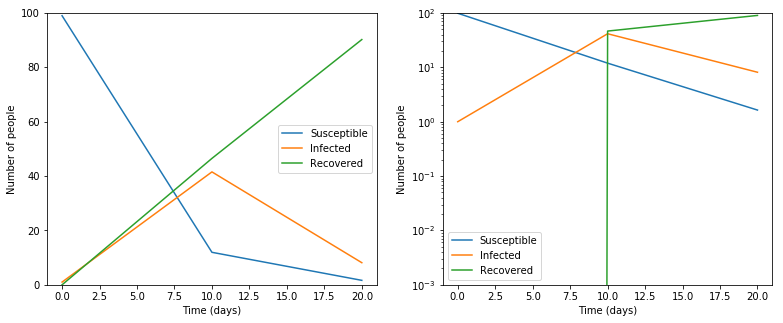

In [8]:
# Другие рандомно выбранные параметры (получше, но опять же плохие)
func, ic = func_getter(0.9, 0.2)
solution = odeint(func, ic, time_points)
plot_data(time_points, solution_to_metrics(solution), 100, labels=["Susceptible", "Infected", "Recovered"])

# 3. Пример модели из найденного нами блокнота про COVID:
## (получилось не особо хорошо)

In [9]:
import pandas as pd

N=1000

# params = [  
#     [6, 7, 8, 9, 10, 11, 12],                                     # IncubPeriod
#     [6, 7, 8, 9, 10],                                             # DurMildInf  
#     [0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925],           # FracMild
#     [0.05, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25],            # FracSevere
#     # FracCritical – autocomputed                                 # FracCritical
#     [0.002, 0.0025, 0.005, 0.006, 0.008, 0.01, 0.02, 0.05, 0.1],  # CFR
#     [5, 6, 7, 8, 9, 10, 11, 12],                                  # TimeICUDeath
#     [13, 14, 15, 16, 17, 18, 19, 20, 21],                         # DurHosp
# ]
# params = [  
#     [8, 9, 10, 11, 12],                                     # IncubPeriod
#     [6, 7, 8, 9, 10],                                             # DurMildInf  
#     [0.75, 0.775, 0.8, 0.825, 0.85],           # FracMild
#     [0.05, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225],            # FracSevere
#     # FracCritical – autocomputed                                 # FracCritical
#     [0.005, 0.006, 0.008, 0.01, 0.02, 0.05, 0.1],  # CFR
#     [6, 7, 8, 9, 10, 11],                                  # TimeICUDeath
#     [16, 17, 18, 19, 20, 21],                         # DurHosp
# ]
# Just for quick testing. Should use the previous block
params = [
    [15, 16, 17, 18, 19],
    [13, 14, 15, 16, 17],
    [0.575, 0.6, 0.625, 0.65, 0.675],
    [0.05, 0.075, 0.1, 0.125, 0.15, 0.175],
    [0.025, 0.04, 0.05, 0.06],
    [10, 11, 12, 14],
    [22, 23, 24, 25, 26, 27],
]

def func_getter(IncubPeriod, DurMildInf, FracMild, FracSevere, CFR, TimeICUDeath, DurHosp):
    # Если набор параметров невалиден, можно просто вернуть None, тогда такой набор будет пропущен
    if FracMild + FracSevere > 1:
        return None
    FracCritical = 1 - FracMild - FracSevere
    
    b=np.zeros(4)
    g=np.zeros(4)
    p=np.zeros(3)

    a=1/IncubPeriod
    u=(1/TimeICUDeath)*(CFR/FracCritical)
    g[3]=(1/TimeICUDeath)-u
    p[2]=(1/DurHosp)*(FracCritical/(FracCritical+FracSevere))
    g[2]=(1/DurHosp)-p[2]
    g[1]=(1/DurMildInf)*FracMild
    p[1]=(1/DurMildInf)-g[1]
    b=2.5e-4*np.array([0,1,0,0])
    
    initial_conditions =np.zeros(6)
    initial_conditions[0] = 1
    
    def ode_system(y,t): 
        # Функция с системой НЕ ПРИНИМАЕТ дополнительные параметры,
        # Но они автоматически "подсасываются" из-за вложенности в func_getter
        dy=[0,0,0,0,0,0]
        S=N-sum(y);
        dy[0] = np.dot(b[1:3],y[1:3])*S-a*y[0] # E
        dy[1] = a*y[0]-(g[1]+p[1])*y[1] #I1
        dy[2] = p[1]*y[1] -(g[2]+p[2])*y[2] #I2
        dy[3] = p[2]*y[2] -(g[3]+u)*y[3] #I3
        dy[4] = np.dot(g[1:3],y[1:3]) #R
        dy[5] = u*y[3] #D

        return dy
    
    return ode_system, initial_conditions

# Наши метрики: infected, recovered, dead
def solution_to_IRD(solution):
    # В нашем случае solution=[susceptible, mild, severe, icu, recovered, dead]
    infected = solution[:, 1] + solution[:, 2] + solution[:, 3]  # i1+i2+i3, without E
    recovered = solution[:, 4]
    dead = solution[:, 5]
    return infected, recovered, dead

# Чутка переделанные метрики: выводим число заболевших на 1000 человек
data = pd.read_csv('https://raw.githubusercontent.com/apugachev/covid-project/master/Moscow_Stats.csv')
MOSCOW_POPULATION = 12600000  # взято откуда-то с википедии
true_ird = (
    data['Заражений'] * 1000 / MOSCOW_POPULATION,
    data['Выздоровлений'] * 1000 / MOSCOW_POPULATION,
    data['Смертей'] * 1000 / MOSCOW_POPULATION,
)
time_points = np.arange(true_ird[0].shape[0])

In [10]:
train_loss, val_loss, best_solution, best_params = fit(
    func_getter,
    time_points,
    params,
    solution_to_IRD,
    true_ird,
    val_samples=0.25,
)
print(round(train_loss, 4), round(val_loss, 4), best_params)


0.5687 10.811 (19, 17, 0.575, 0.125, 0.06, 14, 27)


In [11]:
# Небольшая функция для быстрой отрисовки графичков, объединяющая реальные данные и смоделированные
def plot_data_together(time_points, predicted_data, true_data, upper_limit, labels=None):
    colors = ['b', 'g', 'r', 'y', 'k', 'm']
    if not labels:
        labels = ['']*len(true_data)
    susceptible, infected, recovered = true_data
    
    plt.figure(figsize=(13,5))
    plt.subplot(1,2,1)
    for y_pred, y_true, color, label in zip(predicted_data, true_data, colors, labels):
        plt.plot(time_points, y_true, color+'--', label=label+' (true)', alpha=0.7)
        plt.plot(time_points, y_pred, color, label=label+' (pred)')
        
    plt.xlabel("Time (days)")
    plt.ylabel("Number of people")
    plt.legend()
    plt.ylim([0, upper_limit])

    #Same plot but on log scale
    plt.subplot(1,2,2)
    for y_pred, y_true, color, label in zip(predicted_data, true_data, colors, labels):
        plt.plot(time_points, y_true, color+'--', label=label+' (true)', alpha=0.7)
        plt.plot(time_points, y_pred, color, label=label+' (pred)')
    plt.semilogy()
    plt.xlabel("Time (days)")
    plt.ylabel("Number of people")
    plt.legend()
    plt.ylim([0.001, upper_limit])

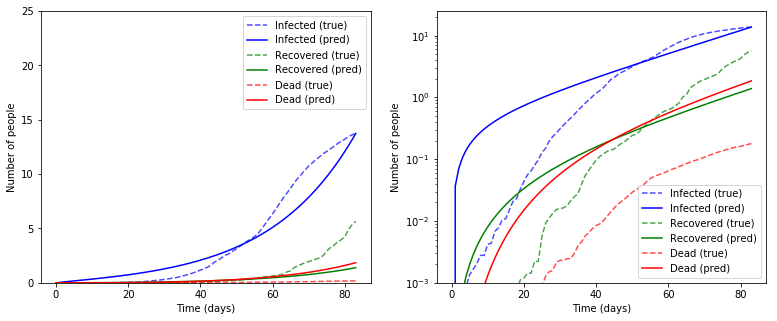

In [12]:
plot_data_together(time_points, solution_to_IRD(best_solution), true_ird, N/40, labels=["Infected", "Recovered", "Dead"])